For introduction and problem statement, please refer to notebook 1

## Content

**Notebook 1: 1_data_cleaning_and_eda**
- Data Import and Cleaning
- Exploratory Data Analysis
- Text Data Pre-processing

**Notebook 2: 2_topic modelling**
- [Data Import](#Data-Import)
- [Topic Modelling with Gensim](#Topic-Modelling-with-Gensim-Library)

**Notebook 3: 3_topic_analysis_and_visualizations**
- Findings and Analysis of Topic Modelling

**Notebook 4: 4_features_extractions_and_sentiment_analysis**
- Data Import
- Sentiment Analysis with VADER
- Sentiment Analysis with Logistic Regression(Multi-Class Classification)
- Evaluation of Sentiment Analysis with BERT(Multi-Class Classification)
Please refer to notebook 5 for the fine-tuning process of pre-trained BERT model


**Notebook 5: 5_fine_tuning_of_BERT_model**   
The reason why this notebook is separated from notebook 4 which contains the evaluation of BERT model is because the fine-tuning of BERT model requires GPU. Hence, the model was fine-tuned on Google Colaboratory and loaded back into notebook 4 for evaluation


**Notebook 6: 6_analysis_and_findings**
- Comparison of the 3 Methods 
- Recommendation and Conclusion 
- Future Steps

## Data Import

In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords

plt.style.use('fivethirtyeight')
%matplotlib inline

#pd.set_option('display.max_colwidth',None)

In [8]:
#reading in the data
new_reviews = pd.read_csv('../data/cleaned_combined_data.csv')

In [9]:
#confirm the shape
new_reviews.shape

(67947, 21)

### Topic Modelling with Gensim Library

In [10]:
# Gensim
from nltk.corpus import stopwords 
import gensim, spacy, logging, warnings
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from pprint import pprint

In [11]:
#convert it to list to feed it to gensim bigram and trigram 
tokens = list(new_reviews['tokens'])

In [12]:
len(tokens)

67947

In [13]:
#Build the bigram and trigram models
bigram = Phrases(tokens, min_count=5, threshold=100)
trigram = Phrases(bigram[tokens], threshold=100)  
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

The adding of stop words here are done in an iterative manners as some of "unimportant words" pop out in the list of keywords in lda output. Hence, I have added those in the stop words as I discover them.

In [14]:
stop_words = stopwords.words('english')
add_words = ['phone','one','two','three','four','five','star','remove', 
             'great', 'nice','get','would','buy','come','also','really','get','best','go','look','make',
            'drop','product','send','even','ever','expect','use','far','flagship']
stop_words.extend(add_words)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN','VERB','ADV']):
    """Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        #only append noun, verb and adverb
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(tokens)  # processed Text Data!

I have removed adjectives from the text data as they result in a lot of noise in Lda output.

In [15]:
import pickle
with open('../data/data_ready_v2.data', 'wb') as filehandle:
    pickle.dump(data_ready, filehandle) # store the data as binary data stream

Saving the processed data using pickle so that we can use the processed data in the subsequent notebook without having to run the codes again.

In [13]:
#create dictionary and mapping the word to unique id
id2word = corpora.Dictionary(data_ready)
#create corpus: term document frequency
corpus = [id2word.doc2bow(line) for line in data_ready]

In [14]:
new_reviews.shape

(67947, 21)

In [15]:
len(corpus)

67947

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models - so that we do not need to re-train the model once we identify the best model
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"Model with {num_topics} topics")
        print(f"Fitting model {num_topics} out of {limit-1}")
        #model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,random_state=42)
        model=LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=num_topics, 
                           random_state=100,
                           chunksize=100,
                           passes=10,
                           iterations=100,
                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v',processes=1)
        print(f"Finding the coherence score of model {num_topics} ")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
#find the optimal number of topics by comparing the coherence scores
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=4, limit=11, step=1)

Model with 4 topics
Fitting model 4 out of 10
Finding the coherence score of model 4 
Model with 5 topics
Fitting model 5 out of 10
Finding the coherence score of model 5 
Model with 6 topics
Fitting model 6 out of 10
Finding the coherence score of model 6 
Model with 7 topics
Fitting model 7 out of 10
Finding the coherence score of model 7 
Model with 8 topics
Fitting model 8 out of 10
Finding the coherence score of model 8 
Model with 9 topics
Fitting model 9 out of 10
Finding the coherence score of model 9 
Model with 10 topics
Fitting model 10 out of 10
Finding the coherence score of model 10 


### Graph showing the coherence values of model with different topic numbers

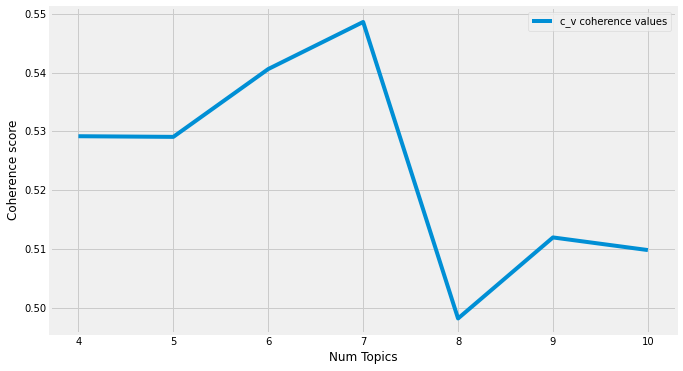

In [19]:
# Show graph
plt.figure(figsize=(10,6))
#limit=11; start=5; step=1;
x = range(4, 11)
plt.plot(x, coherence_values,label='c_v coherence values')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

In [20]:
#putting them on a dataframe
pd.DataFrame((zip(x,coherence_values)),
            columns=['No of topics','Coherence Score(c_v)'])


,No of topics,Coherence Score(c_v)
0,4,0.529175
1,5,0.529066
2,6,0.540592
3,7,0.548595
4,8,0.498200
5,9,0.511972
6,10,0.509825


In [21]:
#defining the best model (model with 7 topics - coherence score 0.55)
best_model = model_list[3]

In [22]:
#save and export the best model
import pickle
filename= '../data/best_topic_model_v2.pkl'
pickle.dump(best_model,open(filename,'wb'))

Below shows the word cloud and keywords of each topic. We will evaluate the Lda output and topics in further details in the subsequent notebook (notebook 3).

In [23]:
pprint(best_model.print_topics(num_words=10))

[(0,
  '0.083*"work" + 0.065*"card" + 0.031*"sim" + 0.023*"wifi" + 0.022*"network" '
  '+ 0.020*"need" + 0.016*"set" + 0.014*"carrier" + 0.014*"datum" + '
  '0.012*"issue"'),
 (1,
  '0.149*"work" + 0.047*"brand" + 0.044*"condition" + 0.036*"seller" + '
  '0.034*"purchase" + 0.029*"arrive" + 0.025*"refurbish" + 0.025*"thank" + '
  '0.025*"well" + 0.023*"price"'),
 (2,
  '0.029*"call" + 0.020*"say" + 0.017*"return" + 0.014*"receive" + 0.013*"try" '
  '+ 0.013*"could" + 0.012*"review" + 0.011*"service" + 0.011*"tell" + '
  '0.011*"unlock"'),
 (3,
  '0.034*"screen" + 0.019*"camera" + 0.015*"app" + 0.011*"case" + 0.010*"time" '
  '+ 0.009*"take" + 0.008*"thing" + 0.008*"feel" + 0.008*"video" + '
  '0.007*"display"'),
 (4,
  '0.082*"love" + 0.073*"price" + 0.041*"camera" + 0.035*"quality" + '
  '0.030*"note" + 0.023*"value" + 0.023*"feature" + 0.014*"picture" + '
  '0.014*"money" + 0.013*"better"'),
 (5,
  '0.070*"work" + 0.054*"month" + 0.040*"issue" + 0.038*"problem" + '
  '0.026*"screen" 

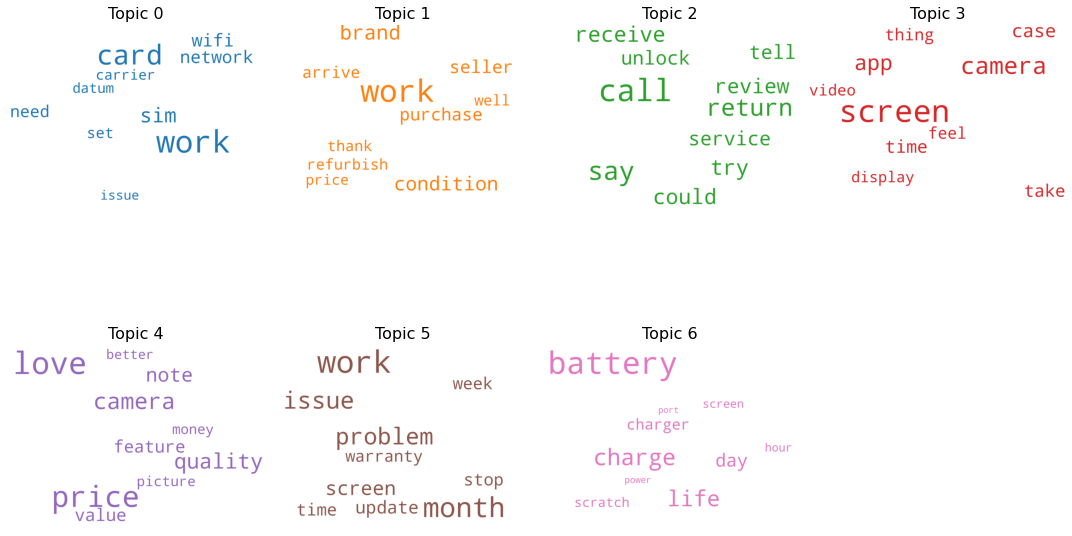

In [24]:
# 1. Wordcloud of Top N words in each topic
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = best_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(15,15))
axes = axes.ravel()
axes[7].set_visible(False)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    if i>=6:
        break


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(h_pad=-30)
plt.show()

#remove great,nice,get,would,buy,come,also,really,get,best,go,look,make,flagship,drop,product,send,even,love,ever,expect,use,far

Discussions on topic modelling output will be done in notebook 3.